In [1]:
import mysql.connector
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pygments.lexers import j
import datetime
from sklearn.neighbors import KernelDensity
from scipy import stats
import KDEpy


In [2]:
## test this - then add catigorical variables
class veeringPhase_frame:
    ## pandas data from to recieve phases from SQL RRP.
    ## frame is then processed to bin variables, define categorical variables
    def __init__(self,rawFrame):
        self.frame = rawFrame.dropna()
        
    def Rename_Columns(self):
        self.frame = self.frame.rename(columns={'BSPpol%':'BSPpolPerc', 'VMG%':'VMGperc', 'BSP_trg%':'BSP_trgPerc'})
        
    def Add_Date_column(self):
        self.frame['Date'] = self.frame['StartTime'].apply(lambda x: x.date())

    def CheckSigns(self,vars):
        for var in vars:
            self.frame[var] = abs(self.frame[var])

    def DefineBins(self,min_max_step):
        ## function takes a list [min, max, step] and defines the bin edges and labels
        min, max, step = min_max_step[0], min_max_step[1]+1, min_max_step[2]
        centres = list(np.arange(min,max,step))
        min = min - (0.5*step)
        max = max + (0.5*step)
        edges = list(np.arange(min,max,step))
        return centres, edges

        
    def Create_Bin_Variables(self,binVars):
        ## function takes a list of variables [varName, newVarName, [min,max,step] and creates a binned variable
        self.binVars = binVars
        for var in self.binVars:
            centres, edges = self.DefineBins(var[2])
            self.frame[var[1]] = pd.cut(self.frame[var[0]], bins=edges, labels=centres)
            
    def Create_Categorical_Variables(self,catVars, cat_threshold):
        ## function changes defined variables to a categorical type and removes categories where the count is < threshold
        self.catVars = catVars
        self.cat_threshold = cat_threshold
        for var in self.catVars:
            self.frame[var] = self.frame[var].astype('category')
            catCount = self.frame.groupby(var,observed=False).size()
            catCount = catCount/sum(catCount)
            drop = catCount[catCount < self.cat_threshold].index
            self.frame[var] = self.frame[var].cat.remove_categories(drop)
    
    def Add_TWS_Weights(self, weights):
        ## add TWS weights to create "equivelant race"
        self.frame = self.frame.merge(weights, left_on='TWS_bin', right_index=True)
        
    def Filter_Sailing_Mode(self,modeList):
        self.modeFrame = []
        for mode in modeList:
            self.modeFrame.append(self.frame.loc[(self.frame.SailingMode == mode)])
        
class veeringDay_frame:
    def __init__(self,frame):
        self.frame = frame
        
    def Filter_Date(self,date_list):
        ## Filter data frame by date to create the "day frame"
        self.year = date_list[0]
        self.month = date_list[1]
        self.day = date_list[2]
        self.dayFrame = self.frame.loc[self.frame.Date == datetime.date(year=self.year,month=self.month,day=self.day)]
        
    def Filter_Race(self,raceNo):
        self.raceFrame = self.dayFrame.loc[(self.frame.RaceNum == raceNo)]

    def Get_TWS_bin_weights(self):
        ## Calculate the TWS bin weights for creating an equivelant race or day
        twsBin_weights = self.dayFrame.groupby('TWS_bin',observed=False).size()/self.dayFrame.groupby('TWS_bin',observed=False).size().sum()
        self.twsBin_weights_day = pd.DataFrame(twsBin_weights, columns=['TWS_bin_weight'])
    
        twsBin_weights = self.raceFrame.groupby('TWS_bin',observed=False).size()/self.raceFrame.groupby('TWS_bin',observed=False).size().sum()
        self.twsBin_weights_race = pd.DataFrame(twsBin_weights, columns=['TWS_bin_weight'])



class veering_Summary:
    ## class takes day frame and extracts summary data for the defined level of granularity
    def __init__(self,frame,granularity):
        self.granularity = granularity
        self.frame = frame
        self.varsDict = {'Chock': [],
                         'D1': [],
                         'D2': [],
                         'V1': [],
                         'Headstay': [],
                         'Mainsail': [],
                         'Headsail': [],
                         'Spinnaker': [],
                         }

    def Get_Races(self):
        ## get race numbers in day
        self.races = list(self.frame.RaceNum.cat.categories)
        self.duration = []

        if self.granularity == 'race':
            for raceNo in self.races:
                self.duration.append(
                    self.frame.loc[self.frame.RaceNum == raceNo, 'StartTime'].max() -
                    self.frame.loc[self.frame.RaceNum == raceNo, 'StartTime'].min())

    def Get_Setting(self):
        ## iterate over each race and each variable and append value for race in the varDict
        for raceNo in self.races:
            for var in self.varsDict.keys():
                self.varsDict[var].append(list(np.unique(self.frame.loc[self.frame.RaceNum == raceNo, var])))

    def Get_TWS_Summary(self):
        ## get tws sumaries and append either for each race or the day pending granularity
        self.TWS_time_x = []
        self.TWS_time_y = []
        self.TWS_binCount_up = []
        self.TWS_binCount_down = []

        if self.granularity == 'race':
            for raceNo in self.races:
                frameFiltered = self.frame.loc[self.frame.RaceNum == raceNo]

                self.TWS_time_x.append(frameFiltered['StartTime'])
                self.TWS_time_y.append(frameFiltered['TWS'])
                self.TWS_binCount_up.append(frameFiltered.loc[frameFiltered.SailingMode == 1].groupby('TWS_bin',observed=False).size())
                self.TWS_binCount_down.append(frameFiltered.loc[frameFiltered.SailingMode == 8].groupby('TWS_bin',observed=False).size())

        elif self.granularity == 'day':
            frameFiltered = self.frame
            self.TWS_time_x.append(frameFiltered['StartTime'])
            self.TWS_time_y.append(frameFiltered['TWS'])
            self.TWS_binCount_up.append(frameFiltered.loc[frameFiltered.SailingMode == 1].groupby('TWS_bin',observed=False).size())
            self.TWS_binCount_down.append(frameFiltered.loc[frameFiltered.SailingMode == 8].groupby('TWS_bin',observed=False).size())



class veering_VMG:
    def __init__(self,granularity, frameHigh, frameLow, filter_threshold):
        self.granularity = granularity
        self.frameHigh = frameHigh
        self.frameLow = frameLow
        self.filter_threshold = filter_threshold

        self.summary_x = []
        self.summary_y = []
        self.summary_avg = []
        #self.summary_sig = []
        self.summary_label = []

        self.wind_low_x = []
        self.wind_low_y = []
        self.wind_high_x = []
        self.wind_high_y = []
        self.wind_low_avg = []
        self.wind_high_avg = []
        #self.wind_sig = []
        self.wind_label = []
        self.TWS_bins = []

    def Get_Summary(self):
        ## iterate over each granularity and calculaute KDE distribution for each and append to summary x and y
        for gran in self.granularity:
            if gran == 'all':
                X = np.asarray(self.frameHigh['VMGperc'])[:, np.newaxis]
                X_weights = np.ones_like(X)
                label = 'All'

            elif gran == 'eq':
                X = np.asarray(self.frameHigh['VMGperc'])[:, np.newaxis]
                X_weights = np.asarray(self.frameHigh['TWS_bin_weight'])[:, np.newaxis]
                label = 'Equivalent'

            elif gran == 'day':
                X = np.asarray(self.frameLow['VMGperc'])[:, np.newaxis]
                X_weights = np.ones_like(X)
                label = 'Day'

            elif granularity == 'race':
                X = np.asarray(self.frameLow['VMGperc'])[:, np.newaxis]
                X_weights = np.ones_like(X)
                label = 'Race'

            try:
                x,y = KDEpy.FFTKDE(kernel='gaussian', bw='ISJ').fit(X,weights=X_weights).evaluate()
                self.summary_x.append(x)
                self.summary_y.append(y)
                self.summary_label.append(label)
                self.summary_avg.append(np.mean(X))

            except:
                self.summary_x.append([])
                self.summary_y.append([])
                self.summary_label.append(label)
                self.self.summary_avg.append([])

            ## if gran is the lowest granularity calculate KDE by wind bins
            if gran == self.granularity[-1]:
                ## check which TWS bins have sufficent entries
                filter = (self.frameLow.groupby('TWS_bin',observed=False).size()/self.frameLow.groupby('TWS_bin',observed=False).size().sum())
                self.TWS_bins = filter[filter > self.filter_threshold].index

                for i in self.TWS_bins:
                    try:
                        X = np.asarray(self.frameLow.loc[self.frameLow['TWS_bin']==i, 'VMGperc'])[:, np.newaxis]
                        x,y = KDEpy.FFTKDE(kernel='gaussian', bw='ISJ').fit(X).evaluate()
                        self.wind_low_x.append(x)
                        self.wind_low_y.append(y)
                        self.wind_label.append(i)
                        self.wind_low_avg.append(np.mean(X))
                    except:
                        self.wind_low_x.append([])
                        self.wind_low_y.append([])
                        self.wind_label.append(i)


                    try:
                        X = np.asarray(self.frameHigh.loc[self.frameHigh['TWS_bin']==i, 'VMGperc'])[:, np.newaxis]
                        x,y = KDEpy.FFTKDE(kernel='gaussian', bw='ISJ').fit(X).evaluate()
                        self.wind_high_x.append(x)
                        self.wind_high_y.append(y)
                        self.wind_high_avg.append(np.mean(X))
                    except:
                        self.wind_high_x.append([])
                        self.wind_high_y.append([])
                        
                        
class veering_Metric:
    def __init__(self,granularity, frameHigh, frameLow, filter_threshold, metrics_dict,metric, centMethod):
        self.granularity = granularity
        self.frameHigh = frameHigh
        self.frameLow = frameLow
        self.filter_threshold = filter_threshold
        self.metrics_dict = metrics_dict
        self.metric = metric
        self.metricList = metrics_dict[metric]
        self.centMethod = centMethod

        self.summary_x = []
        self.summary_y = []
        self.summary_label = []
        self.summary_avg = []

        self.wind_centres = []
        self.wind_centres_labels = []

        self.trgPerc_wind_low_x = []
        self.trgPerc_wind_low_y = []
        self.trgPerc_wind_high_x = []
        self.trgPerc_wind_high_y = []

        self.vmg_wind_highTRG_x = []
        self.vmg_wind_highTRG_y = []
        self.vmg_wind_lowTRG_x = []
        self.vmg_wind_lowTRG_y = []
        self.vmg_wind_lowMD_x = []
        self.vmg_wind_lowMD_y = []
        self.vmg_wind_label = []

    def AvgTRG_To_TRGbin(self,AVGtrg,bins):
        dif = np.abs(np.asarray(bins)-AVGtrg)
        binInd = np.where(dif == dif.min())[0][0]
        bin = np.asarray(bins)[binInd]
        return bin

    def Get_Metrics(self):
        metric_trgperc = self.metricList[2]
        for gran in self.granularity:
            if gran == 'all':
                X = np.asarray(self.frameHigh[metric_trgperc])[:, np.newaxis]
                X_weights = np.ones_like(X)
                label = 'All'

            elif gran == 'eq':
                X = np.asarray(self.frameHigh[metric_trgperc])[:, np.newaxis]
                X_weights = np.asarray(self.frameHigh['TWS_bin_weight'])[:, np.newaxis]
                label = 'Equivalent'

            elif gran == 'day':
                X = np.asarray(self.frameLow[metric_trgperc])[:, np.newaxis]
                X_weights = np.ones_like(X)
                label = 'Day'

            elif granularity == 'race':
                X = np.asarray(self.frameLow[metric_trgperc])[:, np.newaxis]
                X_weights = np.ones_like(X)
                label = 'Race'

            try:
                x,y = KDEpy.FFTKDE(kernel='gaussian', bw='ISJ').fit(X,weights=X_weights).evaluate()
                self.summary_x.append(x)
                self.summary_y.append(y)
                self.summary_label.append(label)
                self.summary_avg.append(np.mean(X))

            except:
                self.summary_x.append([])
                self.summary_y.append([])
                self.summary_label.append(label)
                self.self.summary_avg.append([])
                print("super help me")

            if gran == self.granularity[-1]:
                ## check which TWS bins have sufficent entries
                filter = (self.frameLow.groupby('TWS_bin',observed=False).size()/self.frameLow.groupby('TWS_bin',observed=False).size().sum())
                self.TWS_bins = filter[filter > self.filter_threshold].index
                tws_label = []
                for i in self.TWS_bins:
                    ## create wind frames
                    windFrame_low = self.frameLow.loc[self.frameLow['TWS_bin']==i,[self.metric, self.metricList[0], self.metricList[1], self.metricList[2],'VMGperc']].dropna()
                    ## reduce phases frame to TWS bin of interest
                    windFrame_high = self.frameHigh.loc[self.frameHigh['TWS_bin']==i,[self.metric, self.metricList[0], self.metricList[1], self.metricList[2],'VMGperc']].dropna()
                    ## calculate centres
                    ## create series of observed values
                    X = np.asarray(windFrame_low[self.metric])[:, np.newaxis]
                    ## calculate the average target observed
                    trgMean = np.asarray(windFrame_low[self.metricList[1]]).mean()
                    centres = []
                    for centre in [trgMean, X.mean(),np.median(X),stats.mode(X)[0][0]]:
                        centres.append(self.AvgTRG_To_TRGbin(centre,windFrame_high[self.metricList[0]]))

                    self.wind_centres.append(centres)
                    self.wind_centres_labels.append(i)

                    ## actual TRGperc
                    trgPerc_labels = []
                    try:
                        ## create series of target percents for wind bin and low granularity and fit KDE
                        X = np.asarray(windFrame_low[self.metricList[2]])[:, np.newaxis]
                        x1,y1 = KDEpy.FFTKDE(kernel='gaussian', bw='silverman').fit(X).evaluate()

                        ## create series of target percents for wind and high granularity and fit KDE
                        X = np.asarray(windFrame_high[self.metricList[2]])[:, np.newaxis]
                        x2,y2 = KDEpy.FFTKDE(kernel='gaussian', bw='silverman').fit(X).evaluate()

                        self.trgPerc_wind_low_x.append(x1)
                        self.trgPerc_wind_low_y.append(y1)
                        self.trgPerc_wind_high_x.append(x2)
                        self.trgPerc_wind_high_y.append(y2)

                    except:
                        self.trgPerc_wind_low_x.append([])
                        self.trgPerc_wind_low_y.append([])
                        self.trgPerc_wind_high_x.append([])
                        self.trgPerc_wind_high_y.append([])
                        print("help me")

                    ## VMG perc x 3
                    label_vmg = []
                    try:
                        ## create series of VMG perc for all phases @ target
                        X = np.asarray(windFrame_high.loc[windFrame_high[self.metricList[0]] == centres[0],'VMGperc'])[:, np.newaxis]
                        x,y = KDEpy.FFTKDE(kernel='gaussian', bw='silverman').fit(X).evaluate()
                        self.vmg_wind_highTRG_x.append(x)
                        self.vmg_wind_highTRG_y.append(y)
                        label_vmg.append('VMG All @ TRG')
                        print(str(i)+"TWS - VMG All @ TRG - Bin Size = "+str(len(X)))
                    except:
                        self.vmg_wind_highTRG_x.append([])
                        self.vmg_wind_highTRG_y.append([])
                        label_vmg.append('VMG All @ TRG')
                        print(str(i)+"TWS - FAIL - VMG All @ TRG - Bin Size = "+str(len(X)))
                        break

                    try:
                        ## create series of VMG perc for low granularity @ target
                        X = np.asarray(windFrame_low.loc[windFrame_low[self.metricList[0]] == centres[0],'VMGperc'])[:, np.newaxis]
                        x,y = KDEpy.FFTKDE(kernel='gaussian', bw='silverman').fit(X).evaluate()
                        self.vmg_wind_lowTRG_x.append(x)
                        self.vmg_wind_lowTRG_y.append(y)
                        label_vmg.append('VMG RACE @ TRG')
                        print(str(i)+"TWS - VMG RACE @ TRG - Bin Size = "+str(len(X)))
                    except:
                        self.vmg_wind_lowTRG_x.append([])
                        self.vmg_wind_lowTRG_y.append([])
                        label_vmg.append('VMG RACE @ TRG')
                        print(str(i)+"TWS - FAIL - VMG RACE @ TRG - Bin Size = "+str(len(X)))

                    try:
                        ## create series of VMG perc for low granularity @ mode
                        X = np.asarray(windFrame_low.loc[windFrame_low[self.metricList[0]] == centres[self.centMethod],'VMGperc'])[:, np.newaxis]
                        x,y = KDEpy.FFTKDE(kernel='gaussian', bw='silverman').fit(X).evaluate()
                        self.vmg_wind_lowMD_x.append(x)
                        self.vmg_wind_lowMD_y.append(y)
                        label_vmg.append('VMG RACE @ MODE')
                        print(str(i)+"TWS - VMG RACE @ MODE - Bin Size = "+str(len(X)))
                    except:
                        self.vmg_wind_lowMD_x.append([])
                        self.vmg_wind_lowMD_y.append([])
                        label_vmg.append('VMG RACE @ MODE')
                        print(str(i)+"TWS - FAIL - VMG RACE @ MODE - Bin Size = "+str(len(X)))

                    self.vmg_wind_label.append(label_vmg)


In [3]:
config = {'username':'flyingjennysql',
          'password':'Cape31rrp!',
          'host':'veeringq.ddns.net',
          'port':'3306',
          'database':'flyingjenny'
          }
cnx = mysql.connector.connect(**config)

phasesFrame = veeringPhase_frame(pd.read_sql_query('SELECT StartTime, SailingMode, RaceNum, TWS, TWA, BSP, HEEL, RUDDER, `BSPpol%`, `VMG%`, `BSP_trg%`, BSP_trg, TWA_trg, AWA, FORESTAY, Chock, D1, D2, V1, Headstay, Mainsail, Headsail, Spinnaker FROM t_phase WHERE `VMG%`>50', cnx))

cnx.close()

/var/folders/b5/1kkh0fjj6cqg5n9rk3j623dr0000gn/T/ipykernel_15133/548791299.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  phasesFrame = veeringPhase_frame(pd.read_sql_query('SELECT StartTime, SailingMode, RaceNum, TWS, TWA, BSP, HEEL, RUDDER, `BSPpol%`, `VMG%`, `BSP_trg%`, BSP_trg, TWA_trg, AWA, FORESTAY, Chock, D1, D2, V1, Headstay, Mainsail, Headsail, Spinnaker FROM t_phase WHERE `VMG%`>50', cnx))


In [4]:
checkSignVars = ['TWA']

categoricalVars = ['SailingMode',
                        'RaceNum',
                        'Chock', 
                        'D1',
                        'D2',
                        'V1',
                        'Headstay',
                        'Mainsail',
                        'Headsail',
                        'Spinnaker']

binVars = [['TWS', 'TWS_bin',[1, 30, 2]],
           ['TWA', 'TWA_bin', [20, 165, 1]],
           ['HEEL', 'HEEL_bin', [0, 25, 1]],
           ['RUDDER', 'RUDDER_bin', [-1.6, 3.6, 0.2]],
           ['FORESTAY', 'FORESTAY_bin', [0.2, 2.2, 0.1]],
           ['BSP', 'BSP_bin', [3, 20, 0.1]],
           ['AWA', 'AWA_bin', [10, 150, 1]]]

metrics_dict = {'BSP':['BSP_bin','BSP_trg','BSP_trgPerc']}

date = [2023,6,9]

granularity = ['eq','day']

granularity_vmg = ['eq','day']

granularity_summary = 'race'

raceNo = 3

mode = [1,8]

filter_threshold = 0.1


In [5]:
## basic wrangling of all phases
phasesFrame.Add_Date_column()
phasesFrame.Rename_Columns()
phasesFrame.CheckSigns(checkSignVars)
phasesFrame.Create_Categorical_Variables(categoricalVars,0.01)
phasesFrame.Create_Bin_Variables(binVars)

## calculate bin weights and assign to phases frame, create day frame
frame_day = veeringDay_frame(phasesFrame.frame)
frame_day.Filter_Date(date)
frame_day.Filter_Race(raceNo)
frame_day.Get_TWS_bin_weights()

if granularity[-1] == 'race':
    phasesFrame.Add_TWS_Weights(frame_day.twsBin_weights_race)
    
elif granularity[-1] == 'day':
    phasesFrame.Add_TWS_Weights(frame_day.twsBin_weights_day)

## Run summary before breaking frame into up and down
summary = veering_Summary(frame_day.dayFrame,granularity_summary)
summary.Get_Races()
summary.Get_Setting()
summary.Get_TWS_Summary()

## filter sailing modes and create up and down frames
phasesFrame.Filter_Sailing_Mode(mode)
frame_day_up = veeringDay_frame(phasesFrame.modeFrame[0])
frame_day_down = veeringDay_frame(phasesFrame.modeFrame[1])
 
for frame in [frame_day_up, frame_day_down]:
    frame.Filter_Date(date)
    frame.Filter_Race(raceNo)

vmg = veering_VMG(granularity_vmg, phasesFrame.modeFrame[0] ,frame_day_up.dayFrame, filter_threshold)
vmg.Get_Summary()

bsp = veering_Metric(granularity_vmg, phasesFrame.modeFrame[0] ,frame_day_up.dayFrame, filter_threshold, metrics_dict, 'BSP', 3)
bsp.Get_Metrics()



13TWS - VMG All @ TRG - Bin Size = 9
13TWS - VMG RACE @ TRG - Bin Size = 3
13TWS - VMG RACE @ MODE - Bin Size = 3
15TWS - VMG All @ TRG - Bin Size = 15
15TWS - VMG RACE @ TRG - Bin Size = 4
15TWS - VMG RACE @ MODE - Bin Size = 10
17TWS - VMG All @ TRG - Bin Size = 22
17TWS - VMG RACE @ TRG - Bin Size = 14
17TWS - VMG RACE @ MODE - Bin Size = 9


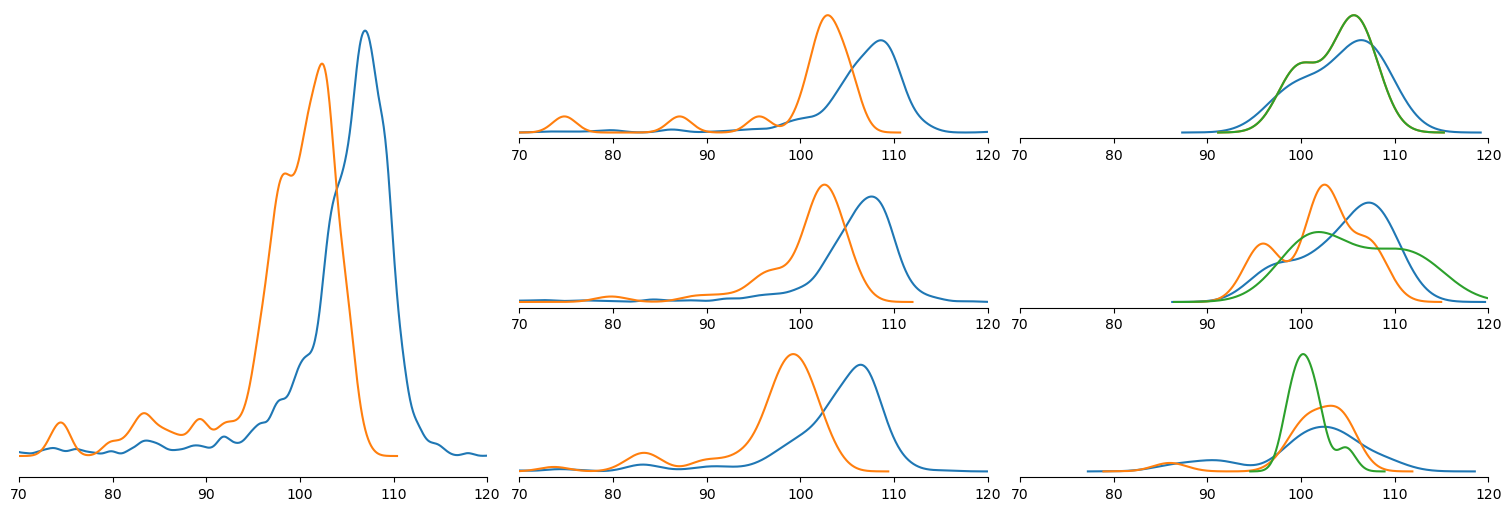

In [7]:
from matplotlib.gridspec import GridSpec
metricVals = bsp

metric_plot = plt.figure(figsize=(15,5),layout='constrained')

gs = GridSpec(len(metricVals.TWS_bins),3, figure=metric_plot)
ax1 = metric_plot.add_subplot(gs[:,0])
ax1.set_xlim(left=70, right=120)
ax1.set_yticks([])
ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['right'].set_visible(False)



middle = []
right = []
for i in range(len(metricVals.TWS_bins)):
    middle.append(metric_plot.add_subplot(gs[i,1]))
    right.append(metric_plot.add_subplot(gs[i,2]))
    
for i in range(len(metricVals.summary_label)):
    ax1.plot(metricVals.summary_x[i],metricVals.summary_y[i], label=metricVals.summary_label[i])

for i in range(len(metricVals.TWS_bins)):
    middle[i].plot(metricVals.trgPerc_wind_high_x[i],metricVals.trgPerc_wind_high_y[i])
    middle[i].plot(metricVals.trgPerc_wind_low_x[i],metricVals.trgPerc_wind_low_y[i])
    middle[i].set_xlim(left=70, right=120)
    middle[i].set_yticks([])
    middle[i].spines['top'].set_visible(False)
    middle[i].spines['left'].set_visible(False)
    middle[i].spines['right'].set_visible(False)

for i in range(len(metricVals.TWS_bins)):
    right[i].plot(metricVals.vmg_wind_highTRG_x[i],metricVals.vmg_wind_highTRG_y[i])
    right[i].plot(metricVals.vmg_wind_lowTRG_x[i],metricVals.vmg_wind_lowTRG_y[i])
    right[i].plot(metricVals.vmg_wind_lowMD_x[i],metricVals.vmg_wind_lowMD_y[i])
    right[i].set_xlim(left=70, right=120)
    right[i].set_yticks([])
    right[i].spines['top'].set_visible(False)
    right[i].spines['left'].set_visible(False)
    right[i].spines['right'].set_visible(False)




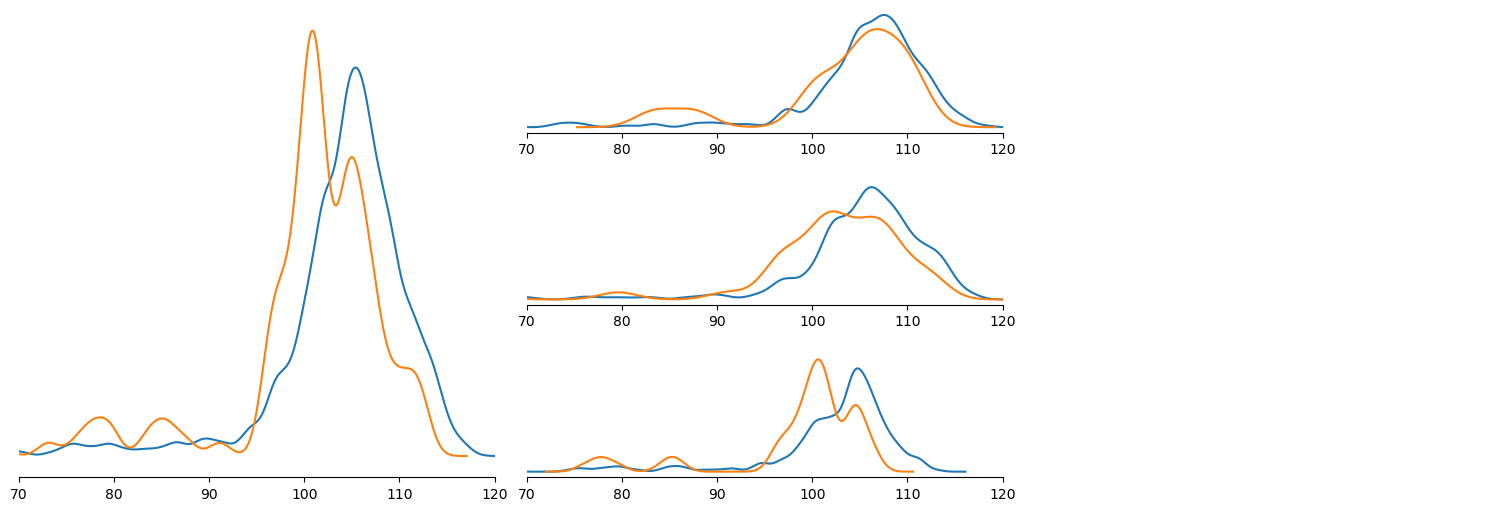

In [8]:
vmgVals = vmg
vmg_plot = plt.figure(figsize=(15,5),layout='constrained')

gs = GridSpec(len(vmgVals.TWS_bins),3, figure=vmg_plot)
ax1 = vmg_plot.add_subplot(gs[:,0])
ax1.set_xlim(left=70, right=120)
ax1.set_yticks([])
ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['right'].set_visible(False)

middle = []

for i in range(len(vmgVals.TWS_bins)):
    middle.append(vmg_plot.add_subplot(gs[i,1]))
    
for i in range(len(vmgVals.summary_label)):
    ax1.plot(vmgVals.summary_x[i],vmgVals.summary_y[i], label=vmgVals.summary_label[i])

for i in range(len(metricVals.TWS_bins)):
    middle[i].plot(vmgVals.wind_high_x[i],vmgVals.wind_high_y[i])
    middle[i].plot(vmgVals.wind_low_x[i],vmgVals.wind_low_y[i])
    middle[i].set_xlim(left=70, right=120)
    middle[i].set_yticks([])
    middle[i].spines['top'].set_visible(False)
    middle[i].spines['left'].set_visible(False)
    middle[i].spines['right'].set_visible(False)

    
ax2 = vmg_plot.add_subplot(gs[:,2])
ax2.set_yticks([])
ax2.set_xticks([])
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)




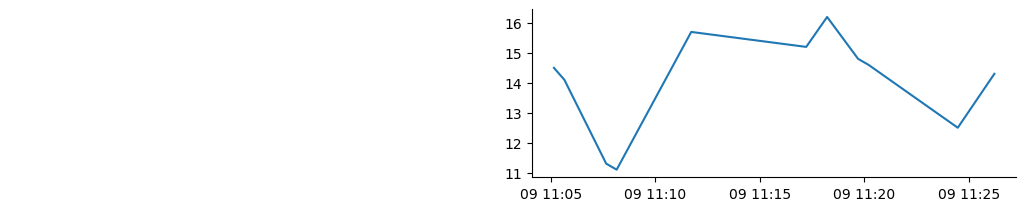

In [9]:
summaryVals = summary
i = 1

summary_plot = plt.figure(figsize=(15,2),layout='constrained')

gs = GridSpec(1,3, figure=summary_plot)
ax1 = summary_plot.add_subplot(gs[:,0])
ax1.set_yticks([])
ax1.set_xticks([])
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['right'].set_visible(False)

ax2 = summary_plot.add_subplot(gs[:,1])
ax2.plot(summaryVals.TWS_time_x[i],summaryVals.TWS_time_y[i])
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)